# HCHO diurnal variability

Note: Data files for hourly observed HCHO are not included in the data archive.

In [1]:
%matplotlib inline

In [2]:
import glob
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import PseudoNetCDF as pnc

In [3]:
workdir = './'
data_dir = f'{workdir}/data'

## obs ICARTT files

### 2023 data

In [4]:
obsdir = '/work/MOD3DEV/tskipper/cracmm_hcho/obs_whitehill'

utc_offset_EST = 5
utc_offset_CST = 6
utc_offset_MST = 7

day_offset = -(366 + 365*3) # 2023 to 2019

In [5]:
def read_ict_2023(fn, utc_offset=5, day_offset=0):
    f = pnc.pncopen(fn, format='ffi1001')
    df = pd.DataFrame(data=f.variables)
    df['dt_LST'] = pd.to_datetime(df['Datetime_EST'], format='%Y%m%d%H%M%S')
    df['dt_LST'] = df['dt_LST'] + pd.to_timedelta(day_offset, unit='d') # move to 2019
    df['dt_UTC'] = df['dt_LST'] + pd.to_timedelta(utc_offset, unit='h')
    df = df.set_index('dt_UTC').resample('1H').mean() # 1 hour averages
    df['LST_hr'] = df['dt_LST'].dt.hour
    df['month'] = df['dt_LST'].dt.month
    return df

In [6]:
# Westport, CT
df_CT23 = read_ict_2023(f'{obsdir}/2023_final/LISTOS2023-HCHO-5min_Westport_20230522_R0.ict', utc_offset=utc_offset_EST, day_offset=day_offset)

# Flax Pond, NY
df_NY23 = read_ict_2023(f'{obsdir}/2023_final/LISTOS2023-HCHO-5min_FlaxPond_20230522_R0.ict', utc_offset=utc_offset_EST, day_offset=day_offset)

# Rutgers, NJ
df_NJ23 = read_ict_2023(f'{obsdir}/2023_final/LISTOS2023-HCHO-5min_Rutgers_20230522_R0.ict', utc_offset=utc_offset_EST, day_offset=day_offset)

### other years

In [7]:
def read_ict(fn, dt0, time_var='Time_Mid_UTC', utc_offset=5, day_offset=0):
    f = pnc.pncopen(fn, format='ffi1001')
    df = pd.DataFrame(data=f.variables)
    df['dt_UTC'] = dt0 + pd.to_timedelta(df[time_var], unit='s') + pd.to_timedelta(day_offset, unit='d')
    df = df.set_index('dt_UTC')
    df['dt_LST'] = df.index - pd.to_timedelta(utc_offset, unit='h')
    df = df.resample('1H').mean()
    df['LST_hr'] = df['dt_LST'].dt.hour
    df['month'] = df['dt_LST'].dt.month
    return df

In [8]:
# Sheboygan, WI (Jun 26 - Jul 22 2017)
fn = f'{obsdir}/HCHO_Sheboygan_20170526_R0_5min.ict'
dt0 = dt.datetime(2017, 6, 26, 0, 0, 0) # origin date in UTC
day_offset = 365*2 # 2017 to 2019
df_WI17 = read_ict(fn, dt0, time_var='Time_Mid_UTC', utc_offset=utc_offset_CST, day_offset=day_offset)

In [9]:
# Salt Lake City, UT (Jan 15 - Feb 14 2017)
fn = f'{obsdir}/HCHO_UU_20170115_R0.ict'
dt0 = dt.datetime(2017, 1, 15, 0, 0, 0) # origin date in UTC
day_offset = 365*2 # 2017 to 2019
df_UT17 = read_ict(fn, dt0, time_var='Time_Mid_UTC', utc_offset=utc_offset_MST, day_offset=day_offset)

In [10]:
# Westport, CT (Jun 21 - Sep 4 2018)
fn = f'{obsdir}/listos-EPAORD-CH2O-insitu_GROUND-WESTPORT_20180621_R0.ict'
dt0 = dt.datetime(2018, 6, 21, 0, 0, 0) # origin date in UTC
day_offset = 365 # 2018 to 2019
df_CT18 = read_ict(fn, dt0, time_var='UTC_Mid', utc_offset=utc_offset_EST, day_offset=day_offset)

## obs csv files

In [11]:
# RTP, NC (Aug 16 - Dec 11 2016)
fn = f'{obsdir}/Formaldehyde_AIRS_RTP_NC_2016_HrAvg.csv'
df_NC16 = pd.read_csv(fn)
df_NC16['dt_EST'] = pd.to_datetime(df_NC16['datetime_EST']) + pd.to_timedelta(365*3, unit='d')
df_NC16['dt_UTC'] = df_NC16['dt_EST'] + pd.to_timedelta(utc_offset_EST, unit='h')
df_NC16 = df_NC16.set_index('dt_UTC')
df_NC16['dt_LST'] = df_NC16.index - pd.to_timedelta(utc_offset_EST, unit='h')
df_NC16['LST_hr'] = df_NC16.dt_LST.dt.hour
df_NC16['month'] = df_NC16['dt_LST'].dt.month

## Atlanta HCHO obs

In [12]:
def process_obs_atl(file_list, utc_offset, gt=False, day_offset=0):
    df = pd.concat([pd.read_csv(f) for f in file_list], ignore_index=True)
    df['dt_UTC'] = pd.to_datetime(df['time_utc']) + pd.to_timedelta(day_offset, unit='d')
    if gt: # set timestamp to start of hour instead of on half hour
        df['dt_UTC'] = df['dt_UTC'] - pd.to_timedelta(0.5, unit='h')
    df = df.set_index('dt_UTC')
    df['dt_LST'] = df.index - pd.to_timedelta(utc_offset, unit='h')
    df['LST_hr'] = df['dt_LST'].dt.hour
    df['month'] = df['dt_LST'].dt.month
    return df

In [13]:
utc_offset_EST = 5
day_offset_2022 = -(365*2+366)
day_offset_2023 = -(365*3+366)
obsdir = '/work/MOD3DEV/tskipper/cracmm_hcho/obs_mouat_atlanta'

sdkdir = f'{obsdir}/SDK_picarro_g2307'
sdk_lat = 33.6878
sdk_lon = -84.2905
df_atl_sdk22 = process_obs_atl(sorted(glob.glob(f'{sdkdir}/g2307_??_2022_R3.csv')), utc_offset_EST, day_offset=day_offset_2022)
df_atl_sdk23 = process_obs_atl(sorted(glob.glob(f'{sdkdir}/g2307_??_2023_R3.csv')), utc_offset_EST, day_offset=day_offset_2023)
# combine sdk 2022 and 2023
df_atl_sdk22 = df_atl_sdk22.rename(columns={'hcho_ppb': 'hcho_ppb_2022'})
df_atl_sdk23 = df_atl_sdk23.rename(columns={'hcho_ppb': 'hcho_ppb_2023'})
df_atl_sdk23 = df_atl_sdk23.merge(df_atl_sdk22['hcho_ppb_2022'], on='dt_UTC', how='outer')

gtdir = f'{obsdir}/GT_aeris_ultra'
gt_lat = 33.778386047268725
gt_lon = -84.39623942837747
df_atl_gt22 = process_obs_atl(sorted(glob.glob(f'{gtdir}/ultra_??_2022.csv')), utc_offset_EST, gt=True, day_offset=day_offset_2022)

### SDK PAMS site

In [14]:
def ugm3_to_ppb(c, mw=30, T=0, P=1):
    """
    Convert from ug/m3 to ppb. Defaults to HCHO at STP conditions.
    
    Arguments
    ---------
    c  : concentation in ug/m3
    mw : molecular weight in g/mol (default HCHO 30 g/mol)
    T  : temperature in deg C (default 0 deg C)
    P  : pressure in atm (default 1 atm)
    
    Returns
    -------
    ppb : mixing ratio in ppb
    """
    
    R = 8.206e-5 # [m3*atm / mol*K]
    ppm = c / mw * R * (T+273.15) / P
    ppb = ppm*1e3
    return ppb

In [15]:
hapf = f'{data_dir}/diurnal/2019_AMA_HAPS_Formaldehyde.txt'
hapdf = pd.read_csv(hapf, sep='|')

/tmp/ipykernel_1175864/915475471.py:2: DtypeWarning: Columns (1,16,26,27,28,33,35,39) have mixed types. Specify dtype option on import or set low_memory=False.
  hapdf = pd.read_csv(hapf, sep='|')


In [16]:
sdk_hap_df = hapdf.query('AQS_PARAMETER_NAME == "Formaldehyde"')
hapdf['dt_LST'] = pd.to_datetime(hapdf['SAMPLE_DATE'] + hapdf['SAMPLE_START_TIME'], format='%m/%d/%Y%H:%M')

# remove sites that have letters:
abc_sites = ['06037BURK', '06037HNPK']
hapdf = hapdf[~hapdf.AMA_SITE_CODE.isin(abc_sites)]

# fix site id; convert HCHO to ppb
hapdf['SiteId'] = pd.to_numeric(hapdf.AMA_SITE_CODE)
hapdf['sample_value_ppb'] = ugm3_to_ppb(hapdf.SAMPLE_VALUE_STD, mw=30, T=0, P=1)

# just SDK site
sdk_pams_df = hapdf.query("SiteId == 130890002")
sdk_pams_8hr_df = sdk_pams_df.query("DURATION_DESC=='8 HOUR'")

In [17]:
sdk_pams_8hr_df_diurnal = sdk_pams_8hr_df[['SAMPLE_START_TIME', 'SAMPLE_VALUE_REPORTED', 'sample_value_ppb']].groupby(by='SAMPLE_START_TIME').mean()
sdk_pams_8hr_df_diurnal['LST_hr'] = [4, 12, 20]

In [18]:
sdk_pams_8hr_hcho_ppb = \
    [sdk_pams_8hr_df_diurnal.loc['20:00'].sample_value_ppb]*2 \
    + [sdk_pams_8hr_df_diurnal.loc['04:00'].sample_value_ppb]*2 \
    + [sdk_pams_8hr_df_diurnal.loc['12:00'].sample_value_ppb]*2 \
    + [sdk_pams_8hr_df_diurnal.loc['20:00'].sample_value_ppb]*2
sdk_pams_8hr_hcho_ugm3 = \
    [sdk_pams_8hr_df_diurnal.loc['20:00'].SAMPLE_VALUE_REPORTED]*2 \
    + [sdk_pams_8hr_df_diurnal.loc['04:00'].SAMPLE_VALUE_REPORTED]*2 \
    + [sdk_pams_8hr_df_diurnal.loc['12:00'].SAMPLE_VALUE_REPORTED]*2 \
    + [sdk_pams_8hr_df_diurnal.loc['20:00'].SAMPLE_VALUE_REPORTED]*2
local_hr_pams = [0, 4, 4, 12, 12, 20, 20, 23]

sdk_pams_diurnal_df = pd.DataFrame(dict(LST_hr=local_hr_pams, hcho_ppb=sdk_pams_8hr_hcho_ppb, hcho_ugm3=sdk_pams_8hr_hcho_ugm3))

## CMAQ data

CMAQ data at observation sites is generated by writesite post processing program.  
Outputs from writesite are by month and are saved in sub-directories based on the post-processed output directory.

In [19]:
def col_renamer(varlist, case):
    return {v: f'{v}_{case}' for v in varlist}

In [20]:
def read_writesite(indir, case, date_glob='2019??'):
    files = sorted(glob.glob(f'{indir}/hcho_hourly_sites_{date_glob}.csv'))
    dfs = [pd.read_csv(f, skiprows=[0,1,2,3,4,6]) for f in files]
    df = pd.concat(dfs, ignore_index=True)
    dt_str = df.eval("date + Time")
    df['dt_UTC'] = pd.to_datetime(dt_str, format='%Y-%m-%d%H:%M:%S')
    df = df.set_index('dt_UTC')
    rename_vars = ['CO', 'O3', 'FORM', 'ISOP']
    df = df.rename(columns=col_renamer(rename_vars, case))
    return df

In [21]:
writesite_dir = f'{data_dir}/diurnal/writesite_outputs'

# annual cases
date_glob = '2019??'
cases_ann = {
    'CRACMM1': 'cracmm1_aq_2019NS42',
    'CRACMM2': 'cracmm2_2019NS43',
}
case_list_ann = list(cases_ann.keys())
cmaq_df_ann = {k: read_writesite(f'{writesite_dir}/{v}', k, date_glob=date_glob) for k, v in cases_ann.items()}

# summer only cases
date_glob = '20190[6-8]'
cases_jja = {
    'CRACMM1':  'cracmm1_aq_2019NS42',    
    'CRACMM2':  'cracmm2_2019NS55',
    'bidi+dep': 'cracmm2_2019NS63a',
}
case_list_jja = list(cases_jja.keys())
cmaq_df_jja = {k: read_writesite(f'{writesite_dir}/{v}', k, date_glob=date_glob) for k, v in cases_jja.items()}

In [22]:
for case, df in cmaq_df_ann.items():
    if case==case_list_ann[0]:
        cmaq_merged_df_ann = df
    else:
        keep_cols = [f'{v}_{case}' for v in ['CO', 'O3', 'FORM', 'ISOP']]
        cmaq_merged_df_ann = pd.concat([cmaq_merged_df_ann, df[keep_cols]], axis='columns')

for case, df in cmaq_df_jja.items():
    if case==case_list_jja[0]:
        cmaq_merged_df_jja = df
    else:
        keep_cols = [f'{v}_{case}' for v in ['CO', 'O3', 'FORM', 'ISOP']]
        cmaq_merged_df_jja = pd.concat([cmaq_merged_df_jja, df[keep_cols]], axis='columns')

## pair obs and cmaq

In [23]:
df_obs_cmaq_CT23 = df_CT23.join(cmaq_merged_df_jja[cmaq_merged_df_jja['siteid']=='WSTPRT_CT'])
df_obs_cmaq_NY23 = df_NY23.join(cmaq_merged_df_jja[cmaq_merged_df_jja['siteid']=='FLXPD_NY'])
df_obs_cmaq_NJ23 = df_NJ23.join(cmaq_merged_df_jja[cmaq_merged_df_jja['siteid']=='RTGRS_NJ'])

df_obs_cmaq_WI17 = df_WI17.join(cmaq_merged_df_jja[cmaq_merged_df_jja['siteid']=='SHBGN_WI'])
df_obs_cmaq_UT17 = df_UT17.join(cmaq_merged_df_ann[cmaq_merged_df_ann['siteid']=='SLC_UT'])
df_obs_cmaq_CT18 = df_CT18.join(cmaq_merged_df_jja[cmaq_merged_df_jja['siteid']=='WSTPRT_CT'])
df_obs_cmaq_NC16 = df_NC16.join(cmaq_merged_df_ann[cmaq_merged_df_ann['siteid']=='RTP_NC'])

In [24]:
df_obs_cmaq_atl_sdk23 = df_atl_sdk23.join(cmaq_merged_df_jja[cmaq_merged_df_jja['siteid']=='ATL_SDK_GA'])
df_obs_cmaq_atl_gt22 = df_atl_gt22.join(cmaq_merged_df_jja[cmaq_merged_df_jja['siteid']=='ATL_GT_GA'])

## diurnal profile plots

In [25]:
plt.rcParams.update({'font.size': 8})

In [26]:
color_list = ['b', 'm', 'g']

In [27]:
def diurnal_ts(df, obsk, title, fig, ax_idx, case_list, color_list=['b','m','g'], xlabel=False, ylabel=False, legend=False, pams_legend=False, ymax=3., get_diurnal=False):
    
    df_diurnal = df.select_dtypes(include='number').groupby(by='LST_hr').mean()
    ax = fig.add_subplot(ax_idx)
    plt.plot(
        df_diurnal.index,
        df_diurnal[obsk],
        'k-',
        label='observed'
    )
    if pams_legend:
        plt.plot([], color='grey', label='PAMS 2019')
    for case, color in zip(case_list, color_list):
        plt.plot(df_diurnal.index,
                 df_diurnal[f'FORM_{case}'],
                 f'{color}-',
                 label=case
        )
    if xlabel:
        plt.xlabel('LST hr')
    plt.xticks(range(0, 25, 4))
    if ylabel:
        plt.ylabel('HCHO (ppb)')
    plt.ylim([0, ymax])
    plt.title(title)
    if legend:
        plt.legend(
            labelcolor='linecolor',
            handlelength=0,
            handletextpad=0,
            frameon=False,
            fontsize=6
        )
    
    if get_diurnal:
        return ax, df_diurnal
    return ax

In [28]:
def diurnal_ts_atl(df, fig, ax_idx, case_list, site='SDK', pams_data=None, xlabel=False, ylabel=False, legend=False, get_diurnal=False):
    
    ax = fig.add_subplot(ax_idx)
    if 'SDK' in site:
        # obs 2022
        plt.plot(
            df.index,
            df.hcho_ppb_2022,
            'k-',
            label='observed'
        )
        # obs 2023
        # plt.plot(
        #     df.index,
        #     df.hcho_ppb_2023,
        #     'k--',
        #     # label='observed'
        # )
    elif 'GT' in site:
        # obs 2022
        plt.plot(
            df.index,
            df.hcho_ppb,
            'k-',
            label='observed'
        )
    # obs PAMS 2019
    if pams_data is not None:
        plt.plot(
            pams_data.LST_hr,
            pams_data.hcho_ppb,
            # pams_data.hcho_ugm3,
            color='grey',
            linestyle='-',
            label='PAMS 2019'
        )
    # mod case1
    for case, color in zip(case_list, color_list):
        plt.plot(
            df.index,
            df[f'FORM_{case}'],
            f'{color}-',
            label=case
        )
    if xlabel:
        plt.xlabel('LST hr')
    plt.xticks(range(0,25,4))
    if ylabel:
        plt.ylabel('HCHO (ppb)')
    # plt.ylim(bottom=0)
    plt.ylim([0, 8])
    plt.title(f'Atlanta {site}')
    if legend:
        plt.legend(
            # loc='right',
            # bbox_to_anchor=(1.4, .5),
            labelcolor='linecolor',
            handlelength=0,
            handletextpad=0,
            frameon=False,
            fontsize=6
        )
    return ax

## diurnal plots

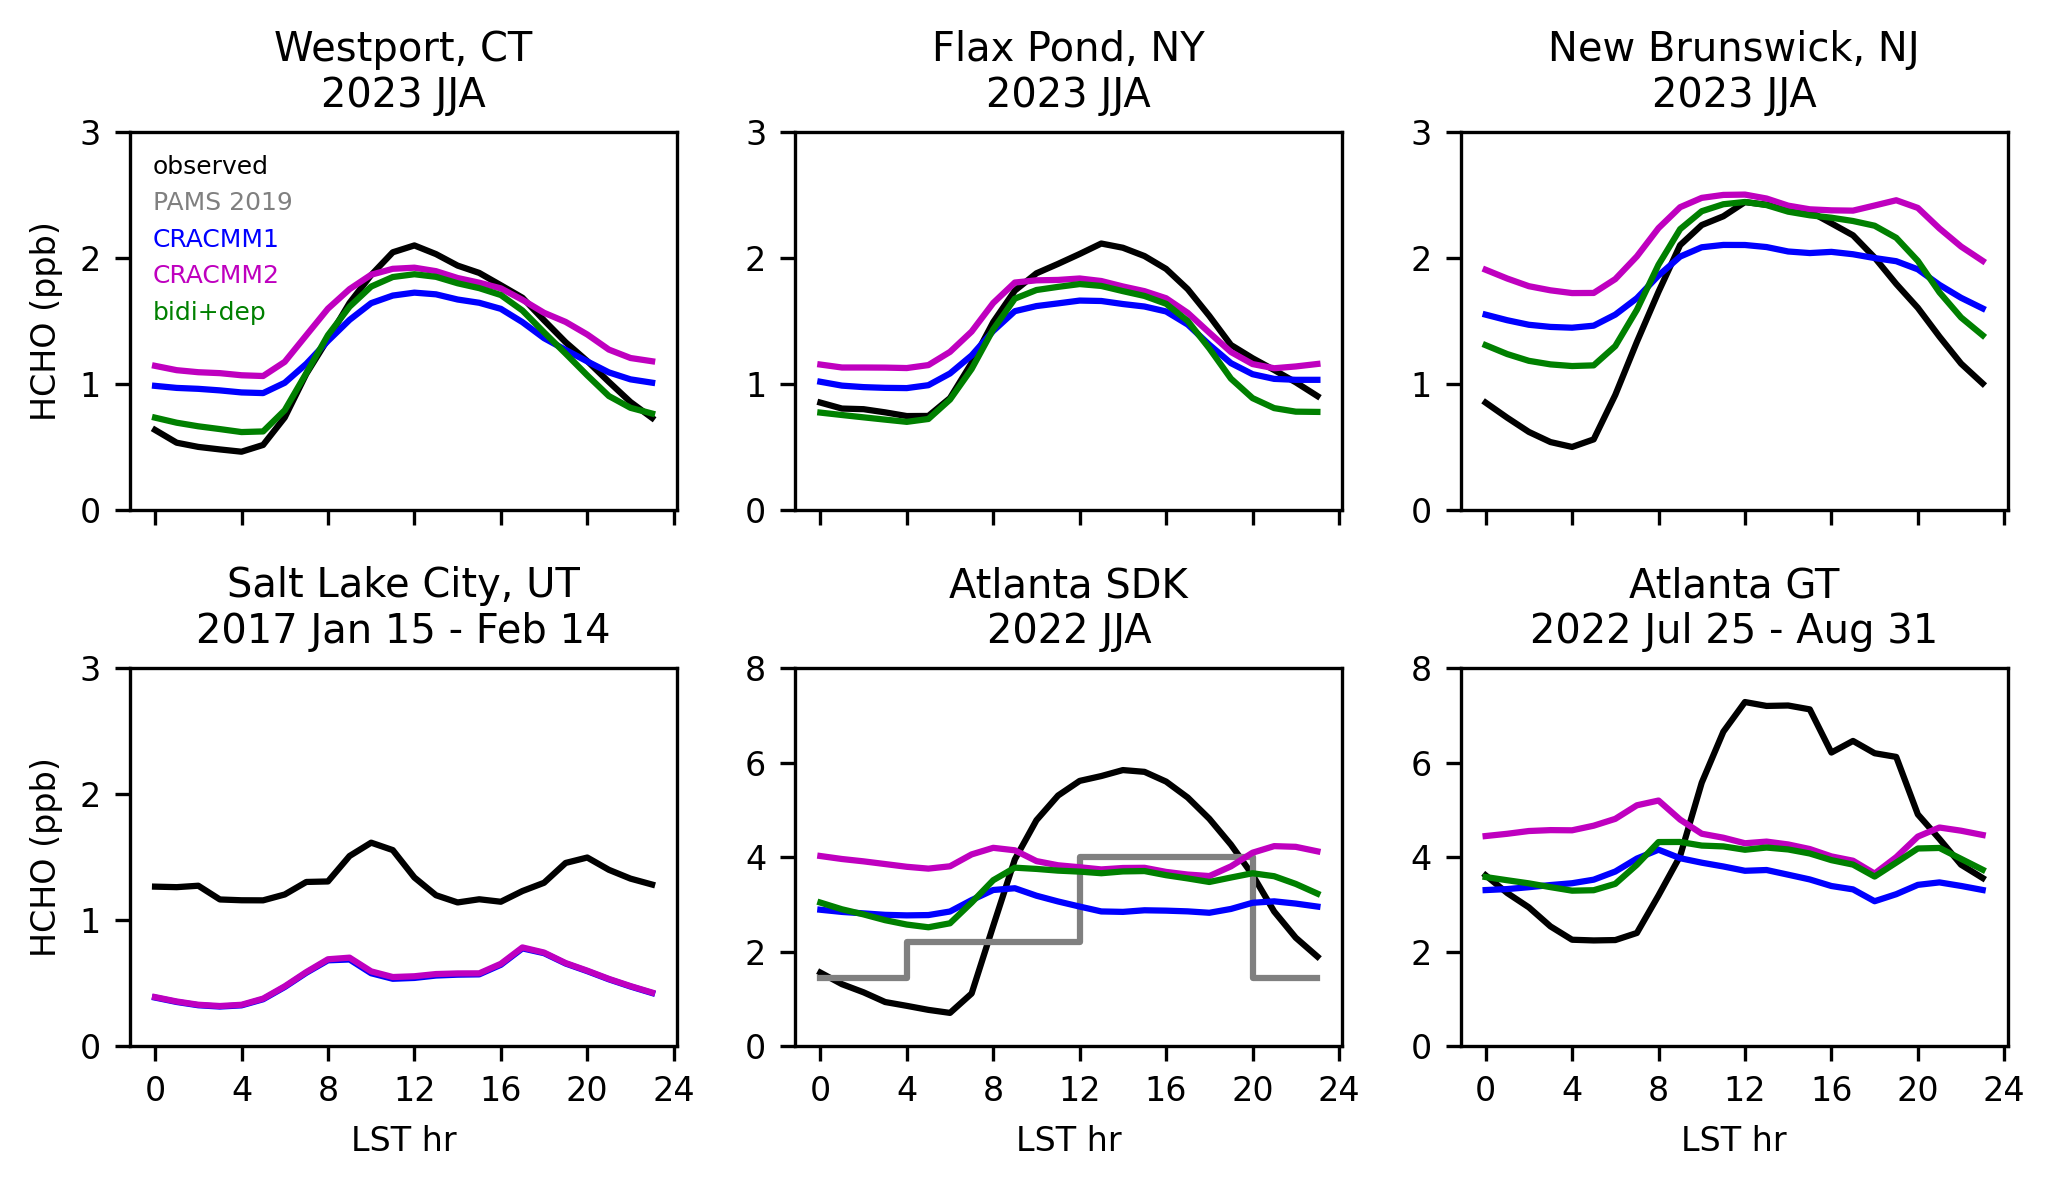

In [29]:
fig = plt.figure(figsize=(7, 4), dpi=300)

# Westport, CT 2023
ax1, diurnal_CT23 = diurnal_ts(
    df_obs_cmaq_CT23[df_obs_cmaq_CT23.month.isin([6, 7, 8])].dropna(subset='Gas_CH2O_InSitu_S_AVMR'), # JJA; drop if no obs
    'Gas_CH2O_InSitu_S_AVMR',
    'Westport, CT\n2023 JJA',
    fig,
    231,
    case_list_jja,
    color_list=color_list,
    ylabel=True,
    legend=True,
    pams_legend=True,
    get_diurnal=True,
    # xlabel=True
)
ax1.tick_params(labelbottom=False, labelsize=8)

# Flax Pond NY 2023
ax2, diurnal_NY23 = diurnal_ts(
    df_obs_cmaq_NY23[df_obs_cmaq_NY23.month.isin([6, 7, 8])].dropna(subset='Gas_CH2O_InSitu_S_AVMR'), # JJA; drop if no obs
    'Gas_CH2O_InSitu_S_AVMR',
    'Flax Pond, NY\n2023 JJA',
    fig,
    232,
    case_list_jja,
    color_list=color_list,
    get_diurnal=True,
    # xlabel=True,
)
ax2.tick_params(labelbottom=False, labelsize=8)

# Rutgers NJ 2023
ax3, diurnal_NJ23 = diurnal_ts(
    df_obs_cmaq_NJ23[df_obs_cmaq_NJ23.month.isin([6, 7, 8])].dropna(subset='Gas_CH2O_InSitu_S_AVMR'), # JJA; drop if no obs
    'Gas_CH2O_InSitu_S_AVMR',
    'New Brunswick, NJ\n2023 JJA',
    fig,
    233,
    case_list_jja,
    color_list=color_list,
    get_diurnal=True,
    # xlabel=True,
)
ax3.tick_params(labelbottom=False, labelsize=8)

# Salt Lake City UT 2017
# remove days during PCAP events
# PCAP events happened 13-20 Jan, 27 Jan - 4 Feb, and 13-18 Feb
date1 = dt.datetime(2019,1,20)
date2 = dt.datetime(2019,1,27)
date3 = dt.datetime(2019,2,4)
date4 = dt.datetime(2019,2,13)
df_obs_cmaq_UT17_noPCAP = df_obs_cmaq_UT17.query("dt_UTC>@date1").query("dt_UTC<@date2 or dt_UTC>@date3").query("dt_UTC<@date4")
ax4, diurnal_UT17_noPCAP = diurnal_ts(
    df_obs_cmaq_UT17_noPCAP.dropna(subset='HCHO_ppb'), # drop if no obs
    'HCHO_ppb',
    'Salt Lake City, UT\n2017 Jan 15 - Feb 14',
    fig,
    234,
    case_list_ann,
    color_list=color_list,
    xlabel=True,
    ylabel=True,
    # legend=True,
    get_diurnal=True
)
ax4.tick_params(labelsize=8)

# Atlanta SDK
df_obs_cmaq_atl_sdk23_JJA = df_obs_cmaq_atl_sdk23[df_obs_cmaq_atl_sdk23.month.isin([6, 7, 8])].dropna(subset='hcho_ppb_2022') # JJA; drop if no obs
df_obs_cmaq_atl_sdk23_JJA_diurnal = df_obs_cmaq_atl_sdk23_JJA.select_dtypes(include='number').groupby(by='LST_hr').mean()
ax5 = diurnal_ts_atl(
    df_obs_cmaq_atl_sdk23_JJA_diurnal,
    fig,
    235,
    case_list_jja,
    site='SDK\n2022 JJA',
    pams_data=sdk_pams_diurnal_df,
    # pams_data=None,
    xlabel=True,
    # legend=True
)
ax5.tick_params(labelsize=8)

# Atlanta GT
df_obs_cmaq_atl_gt22_JJA = df_obs_cmaq_atl_gt22[df_obs_cmaq_atl_gt22.month.isin([6, 7, 8])].dropna(subset='hcho_ppb') # JJA; drop if no obs
df_obs_cmaq_atl_gt22_JJA_diurnal = df_obs_cmaq_atl_gt22_JJA.select_dtypes(include='number').groupby(by='LST_hr').mean()
ax6 = diurnal_ts_atl(
    df_obs_cmaq_atl_gt22_JJA_diurnal,
    fig,
    236,
    case_list_jja,
    site='GT\n2022 Jul 25 - Aug 31',
    xlabel=True
)
ax6.tick_params(labelsize=8)

plt.tight_layout()

## additional sites for SI figure

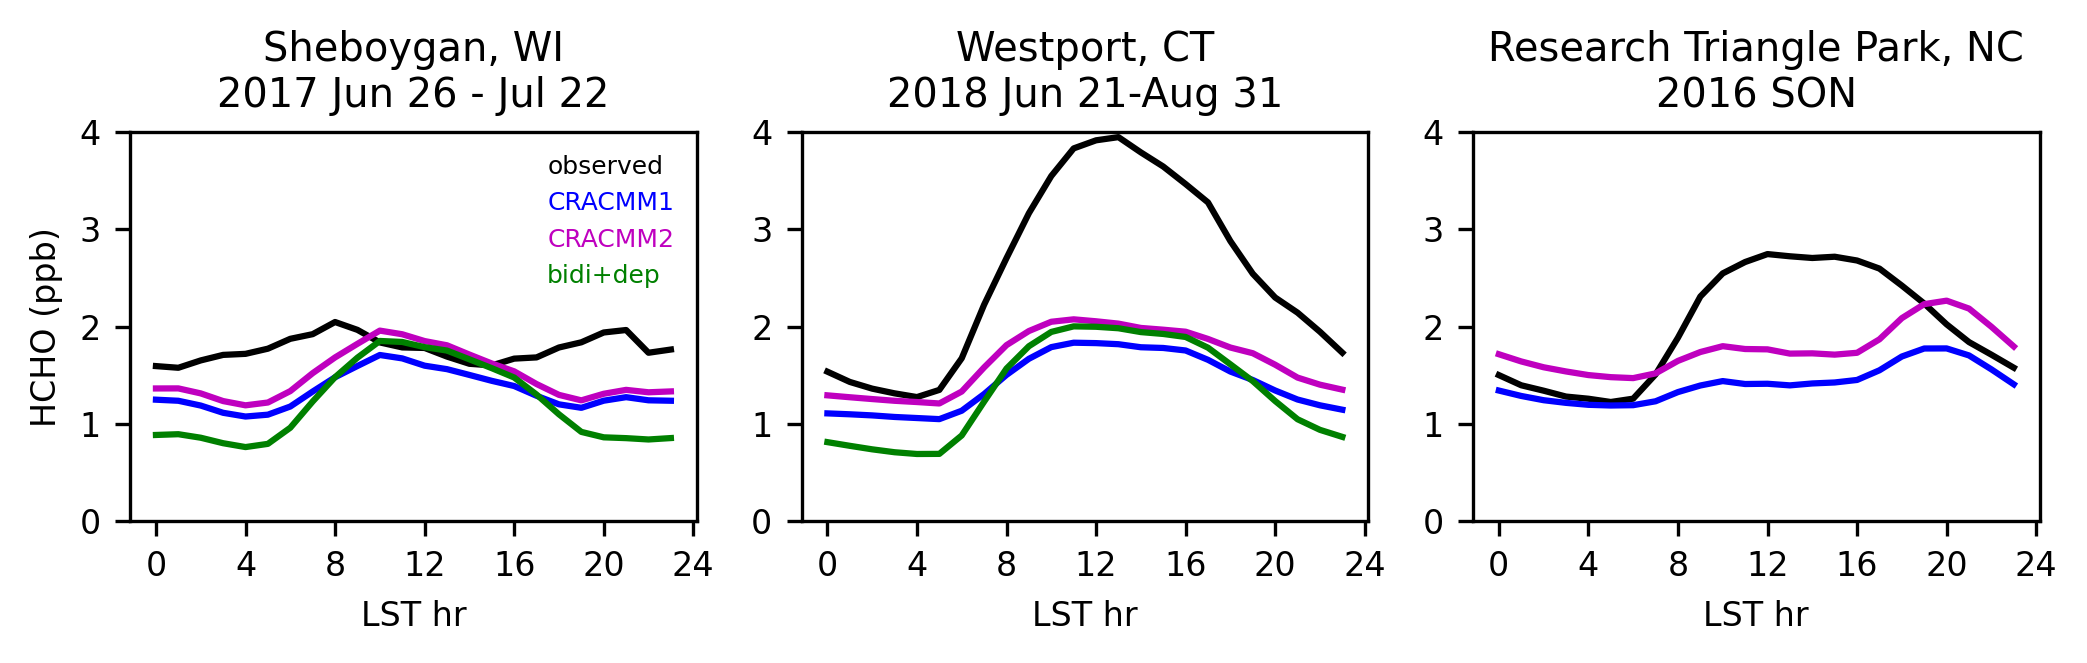

In [30]:
fig = plt.figure(figsize=(7, 2.25), dpi=300)

# Sheboygan WI 2017
ax1 = diurnal_ts(
    df_obs_cmaq_WI17.dropna(subset='HCHO_ppb'),
    'HCHO_ppb',
    'Sheboygan, WI\n2017 Jun 26 - Jul 22',
    fig,
    131,
    case_list_jja,
    color_list=color_list,
    ylabel=True,
    xlabel=True,
    legend=True,
    ymax=4
)
ax1.tick_params(labelsize=8)

# Westport CT 2018
ax2 = diurnal_ts(
    df_obs_cmaq_CT18.dropna(subset='CH2O_ppb'),
    'CH2O_ppb',
    'Westport, CT\n2018 Jun 21-Aug 31',
    fig,
    132,
    case_list_jja,
    color_list=color_list,
    xlabel=True,
    ymax=4
)
ax2.tick_params(labelsize=8)

# RTP NC 2016
ax3 = diurnal_ts(
    df_obs_cmaq_NC16[df_obs_cmaq_NC16.month.isin([9, 10, 11])].dropna(subset='CH2O_ppb'), # SON
    'CH2O_ppb',
    'Research Triangle Park, NC\n2016 SON',
    fig,
    133,
    case_list_ann,
    color_list=color_list,
    xlabel=True,
    ymax=4
)
ax3.tick_params(labelsize=8)

plt.tight_layout()